# PCA plot generation UKBB data

The intention of this notebook is to generate the PCA plots for the exome samples.

Steps to generate a PCA include removing related individuals, pruning variants in linkage disequilibrium (LD), and excluding outlier samples that can suggest poor genotyping quality or distant relatedness (also restrict to individuals of homogeneous ancestry).

Pitfalls
1. Some of the PCs may capture LD structure rather than population structure (decrease in power to detect associations in these regions of high LD)
2. When projecting a new study dataset to the PCA space computed from a reference dataset: projected PCs are shrunk toward 0 in the new dataset 
3.  PC scores may capture outliers that are due to family structure, population structure or other reasons; it might be beneficial to detect and remove these individuals to maximize the population structure captured by PCA (in the case of removing a few outliers) or to restrict analyses to genetically homogeneous samples


## Identify and select the 200K individuals from exome sequencing

In [7]:
#Load libraries
library(plyr)
library(tidyverse)
library(pander)
library(ggpubr)
library(rapportools)
library(ggplot2)
#Get working directory
getwd()
#Set working directory
setwd('/gpfs/gibbs/pi/dewan/data/UKBiobank/phenotype_files/pleiotropy_R01/ukb43978_OCT2020/dc2325_phenotypes')

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::arrange()   masks plyr::arrange()
✖ purrr::compact()   masks plyr::compact()
✖ dplyr::count()     masks plyr::count()
✖ dplyr::failwith()  masks plyr::failwith()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::id()        masks plyr::id()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::mutate()    masks plyr::mutate()
✖ dplyr::rename()    masks plyr::rename()
✖ dplyr::summarise() masks plyr::summarise()
✖ dplyr::summarize() masks plyr::summarize()

Loading required package: magrittr

Warning message:
“package ‘magrittr’ was built under R version 3.6.3”

Attaching package: ‘magrittr’


The following object is masked from ‘package:purrr’:

    set_names


The following ob

[1] "/gpfs/ysm/project/dewan/dc2325/UKBB_GWAS_dev"

In [2]:
# Clean workspace
rm(list=ls())

In [2]:
fam <- read.table("/gpfs/gibbs/pi/dewan/data/UKBiobank/genotype_files/ukb28374_exomedata/exome_data_OCT2020/ukb23155_s200631.fam", sep=' ', header=F)
colnames(fam) <- c("FID","IID","fatherID", "motherID", "sex", "phenotype")
head(fam)
dim(fam)

,FID,IID,fatherID,motherID,sex,phenotype
,<int>,<int>,<int>,<int>,<int>,<int>
1,1434748,1434748,0,0,2,-9
2,5523981,5523981,0,0,1,-9
3,5023838,5023838,0,0,2,-9
4,4023729,4023729,0,0,1,-9
5,4442146,4442146,0,0,2,-9
6,5654789,5654789,0,0,2,-9


[1] 200643      6

In [1]:
# Import the database to R with all the variable codings
bd <- read.table("/gpfs/gibbs/pi/dewan/data/UKBiobank/phenotype_files/pleiotropy_R01/ukb42495_updatedJune2020/ukb42495.tab", sep="\t", header=T)

In [3]:
#Number or rows in bd
dim(bd)
head(bd[,1, drop=FALSE])

[1] 502505   6613

,f.eid
,<int>
1,6025442
2,1000019
3,1000022
4,1000035
5,1000046
6,1000054


In [4]:
# Assign individual ID column to bd f.eid
names(bd)[1] <- "IID"
head(bd[,1, drop=FALSE])

,IID
,<int>
1,6025442
2,1000019
3,1000022
4,1000035
5,1000046
6,1000054


In [39]:
bd_pca <- bd %>%  
    select(IID,
           starts_with("f.22009"),
           starts_with("f.22006"),
           starts_with("f.21000")) %>%
    mutate(WES=if_else(IID%in%exomed_IID,"1","0"))

In [40]:
head(bd_pca)
dim(bd_pca)

,IID,f.22009.0.1,f.22009.0.2,f.22009.0.3,f.22009.0.4,f.22009.0.5,f.22009.0.6,f.22009.0.7,f.22009.0.8,f.22009.0.9,⋯,f.22009.0.36,f.22009.0.37,f.22009.0.38,f.22009.0.39,f.22009.0.40,f.22006.0.0,f.21000.0.0,f.21000.1.0,f.21000.2.0,WES
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<chr>
1,6025442,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,0
2,1000019,-12.2053,4.76174,-4.25570,3.40438,-0.658608,0.782260,2.46875,0.870685,-8.79311,⋯,3.41345,-3.65638,-0.146136,-1.74808,0.0766507,1,1001,NA,NA,1
3,1000022,-11.0907,2.93694,-2.83272,-1.16121,-7.517080,-3.193180,-1.38290,-1.901870,1.65703,⋯,-3.98978,3.35086,-0.226358,-1.64457,-2.7941000,1,1001,NA,NA,0
4,1000035,-15.2753,1.34975,-2.99361,8.39502,17.040800,1.702570,-1.47434,0.977063,4.29165,⋯,1.29770,-1.60734,1.774000,-2.62669,1.6079300,1,1001,NA,NA,1
5,1000046,-13.8809,5.01353,-1.77091,3.73010,6.774160,-2.293770,1.76893,-0.409260,2.27147,⋯,2.52143,1.84519,0.518179,-1.97682,3.8931000,1,1001,NA,NA,0
6,1000054,-13.4765,6.71309,-3.98852,4.35470,8.732250,-0.496887,3.40731,0.491270,1.17219,⋯,1.24627,-1.84256,-2.977780,-2.09987,0.2277160,1,1001,NA,NA,0


[1] 502505     46

In [5]:
# Select the 200K individuals from the full db
exomed_ind <- bd[bd$IID %in% fam$IID,]
# Save as csv file
#write.csv(exomed_ind,'112420_ukb42495_exomed_ind.csv', row.names = FALSE)

In [32]:
exomed_IID <- exomed_ind[, "IID"]

In [17]:
ethnicity <- exomed_ind %>%
    select(IID, starts_with("f.21000"))

In [18]:
head(ethnicity)
dim(ethnicity)

,IID,f.21000.0.0,f.21000.1.0,f.21000.2.0
,<int>,<int>,<int>,<int>
2,1000019,1001,NA,NA
4,1000035,1001,NA,NA
8,1000078,1001,1001,1001
9,1000081,1001,NA,NA
20,1000198,1001,NA,NA
22,1000210,1001,NA,NA


[1] 200631      4

In [19]:
# Function to extract all the available answers for 4 visits
# and put them in one list
f<-function(x){
  visit<-c()
  for (i in 2:4){
    if (!is.na(x[i]))
    {visit<-c(visit,x[i])}
  }
  if(is.null(visit)){visit=NA}
  else{visit=as.numeric(visit)}
  return (visit)
}

# Apply the above function and remove NAs
ethnicity$visit<-apply(ethnicity, 1, f)

In [20]:
head(ethnicity)
dim(ethnicity)

,IID,f.21000.0.0,f.21000.1.0,f.21000.2.0,visit
,<int>,<int>,<int>,<int>,<named list>
2,1000019,1001,NA,NA,1001
4,1000035,1001,NA,NA,1001
8,1000078,1001,1001,1001,"1001, 1001, 1001"
9,1000081,1001,NA,NA,1001
20,1000198,1001,NA,NA,1001
22,1000210,1001,NA,NA,1001


[1] 200631      5

In [21]:
ethnicity <- ethnicity %>%
  filter(!is.na(visit))
dim(ethnicity)

[1] 200419      5

In [29]:
# Function to get the final code for ethnicity
f<-function(x){
  l=length(x$visit)
  if (l==1){ # only one answer available
    result=x$visit
  }
  else{ # more then one answer available
    result=x$visit[1]
    for (i in 2:l){
      if (x$visit[i] == x$visit[i-1]){result=x$visit[i]} # consistent ones
      else {result=NA; break} # inconsistent ones
    }
  }
  return(result)
}

# Apply the above function and remove NAs
ethnicity$new_ethnicity<-apply(ethnicity, 1, f)
ethnicity_noNA<-ethnicity %>%
  filter(!is.na(new_ethnicity))
ethnicity_isNA <- ethnicity %>%
  filter(is.na(new_ethnicity))
head(ethnicity_noNA, 1000) # note: noise_wp code generated here is numeric, not factor
dim(ethnicity_noNA)
dim(ethnicity)

,IID,f.21000.0.0,f.21000.1.0,f.21000.2.0,visit,new_ethnicity
,<int>,<int>,<int>,<int>,<named list>,<dbl>
1,1000019,1001,NA,NA,1001,1001
2,1000035,1001,NA,NA,1001,1001
3,1000078,1001,1001,1001,"1001, 1001, 1001",1001
4,1000081,1001,NA,NA,1001,1001
5,1000198,1001,NA,NA,1001,1001
6,1000210,1001,NA,NA,1001,1001
7,1000224,1001,NA,NA,1001,1001
8,1000236,1001,NA,NA,1001,1001
9,1000255,1001,NA,NA,1001,1001


[1] 199865      6

[1] 200419      6

In [30]:
head(ethnicity_isNA, 50)
nrow(ethnicity_isNA)

,IID,f.21000.0.0,f.21000.1.0,f.21000.2.0,visit,new_ethnicity
,<int>,<int>,<int>,<int>,<named list>,<dbl>
1,1007061,1002,NA,1001,"1002, 1001",NA
2,1057984,-3,NA,1001,"-3, 1001",NA
3,1059988,1001,1002,1001,"1001, 1002, 1001",NA
4,1077383,1001,1002,NA,"1001, 1002",NA
5,1108028,1001,1002,NA,"1001, 1002",NA
6,1109575,1001,NA,6,"1001, 6",NA
7,1110004,1001,-3,NA,"1001, -3",NA
8,1111668,1003,1001,NA,"1003, 1001",NA
9,1133245,1003,1001,NA,"1003, 1001",NA


[1] 554

In [8]:
dim(exomed_ind)

[1] 200631   6613

In [20]:
cols_pca <- exomed_ind %>% 
    select(starts_with("f.22009"),
           starts_with("f.22006"),
          starts_with("f.21000")) %>%
    mutate(ethnicity = case_when(
         f.21000.0.0 == 1001 ~  "British",
         f.21000.0.0 == 2001 ~ "White and Black Caribbean",
         f.21000.0.0 == 3001 ~  "Indian",
         f.21000.0.0 == 4001 ~ "Caribbean",
         f.21000.0.0 == 1002 ~ "Irish",
         f.21000.0.0 == 2002 ~ "White and Black African",
         f.21000.0.0 == 3002 ~ "Pakistani",
         f.21000.0.0 == 4002 ~ "African",
         f.21000.0.0 == 1003 ~ "Any other white background",
         f.21000.0.0 == 2003 ~ "White and Asian",
         f.21000.0.0 == 3003 ~ "Bangladeshi",
         f.21000.0.0 == 4003 ~ "Any other Black background",
         TRUE  ~ ""))
head(cols_pca, 20)
dim(cols_pca)

,f.22009.0.1,f.22009.0.2,f.22009.0.3,f.22009.0.4,f.22009.0.5,f.22009.0.6,f.22009.0.7,f.22009.0.8,f.22009.0.9,f.22009.0.10,⋯,f.22009.0.36,f.22009.0.37,f.22009.0.38,f.22009.0.39,f.22009.0.40,f.22006.0.0,f.21000.0.0,f.21000.1.0,f.21000.2.0,ethnicity
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<chr>
1,-12.20530,4.761740,-4.255700,3.4043800,-0.658608,0.78226000,2.468750,0.870685,-8.793110,-3.1999600,⋯,3.413450,-3.65638000,-0.146136,-1.748080,0.0766507,1,1001,NA,NA,British
2,-15.27530,1.349750,-2.993610,8.3950200,17.040800,1.70257000,-1.474340,0.977063,4.291650,-1.3963400,⋯,1.297700,-1.60734000,1.774000,-2.626690,1.6079300,1,1001,NA,NA,British
3,-14.57510,1.273820,-0.340971,2.3926800,-6.357220,-1.90924000,-1.600680,-1.232460,3.727050,1.1607600,⋯,-0.156930,1.41995000,3.883190,-1.411200,3.9230900,1,1001,1001,1001,British
4,24.35170,-4.644310,24.033900,-56.1452000,0.190955,3.15749000,27.519800,14.322100,1.408310,-6.3385700,⋯,-2.511610,0.00500915,1.827430,-1.563660,0.4964910,NA,1001,NA,NA,British
5,-15.78040,3.962180,-1.457960,5.2719400,9.916450,4.23839000,-0.722502,-1.284130,0.322347,0.1692190,⋯,2.831490,-1.05011000,2.835350,-1.409780,0.3667280,1,1001,NA,NA,British
6,-12.56780,6.088840,-2.566460,2.9077400,2.502850,0.10934700,0.326844,1.261680,3.922510,-2.5773800,⋯,0.659752,-2.89490000,-0.507303,-1.371300,0.5078900,1,1001,NA,NA,British
7,-12.55110,2.150950,-3.043000,1.4999500,5.775890,1.18588000,0.545663,1.865930,1.835150,-4.5444600,⋯,0.913506,-2.10550000,-1.862260,-0.127049,-0.6747940,1,1001,NA,NA,British
8,-12.87260,1.699260,0.921848,-0.5668110,-8.891500,3.32152000,-6.305480,6.955560,0.995671,0.4382940,⋯,1.429630,-0.75117800,4.445330,-0.584504,-0.7488080,1,1001,NA,NA,British
9,-10.13260,4.426480,-2.594010,3.8819100,0.707248,0.07102270,-1.011700,-2.050420,-1.547130,0.3264850,⋯,3.218210,-1.33985000,-2.037830,3.560450,4.6788000,1,1001,NA,NA,British


[1] 200631     45

In [10]:
white_brit <- cols_pca %>%
        filter(f.22006.0.0==1)
nrow(white_brit)

[1] 167248

In [65]:
png(file="PC1vPC2_exomed_ind.png",  width = 5, height = 5, unit='in', res=300)
ggplot(cols_pca, aes(x=f.22009.0.1, y=f.22009.0.2))+ geom_point(aes(color=f.22006.0.0)) +
    labs(title="PC1 vs PC2 exomed subset",
       x="PC1", y = "PC2") +
    theme_classic()
dev.off()

Warning message:
“Removed 174 rows containing missing values (geom_point).”


png 
  2

In [66]:
png(file="PC3vPC4_exomed_ind.png",  width = 5, height = 5, unit='in', res=300)
ggplot(cols_pca, aes(x=f.22009.0.3, y=f.22009.0.4))+ geom_point(aes(color=f.22006.0.0)) +
    labs(title="PC3 vs PC4 exomed subset",
       x="PC3", y = "PC4") +
    theme_classic()
dev.off()

Warning message:
“Removed 174 rows containing missing values (geom_point).”


png 
  2

In [67]:
png(file="PC5vPC6_exomed_ind.png", width = 5, height = 5, unit='in', res=300)
ggplot(cols_pca, aes(x=f.22009.0.5, y=f.22009.0.6))+ geom_point(aes(color=f.22006.0.0)) +
    labs(title="PC5 vs PC6 exomed subset",
       x="PC5", y = "PC6") +
    theme_classic()
dev.off()

Warning message:
“Removed 174 rows containing missing values (geom_point).”


png 
  2

Warning message:
“Removed 174 rows containing missing values (geom_point).”


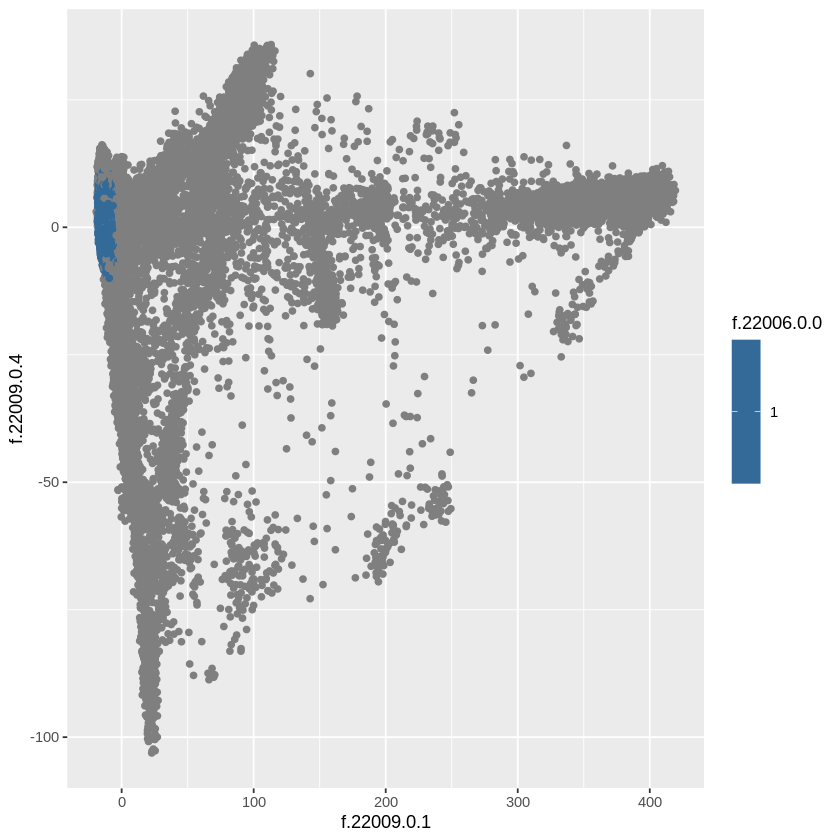

In [26]:
ggplot(cols_pca, aes(x=f.22009.0.1, y=f.22009.0.4))+ geom_point(aes(color=f.22006.0.0))

In [68]:
png(file="PC1vPC2_fulldb_byWES.png", width = 5, height = 5, unit='in', res=300)
ggplot(bd_pca, aes(x=f.22009.0.1, y=f.22009.0.2))+ geom_point(aes(color=WES, shape=WES))+
    labs(title="PC1 vs PC2 total sample by WES",
       x="PC1", y = "PC2") +
    theme_classic()
dev.off()

Warning message:
“Removed 14242 rows containing missing values (geom_point).”


png 
  2

In [45]:
length(which(bd_pca$WES == 1))

[1] 200631

In [ ]:
[global]
# the output directory for generated files
parameter: cwd = path
# Plink files for exome data
parameter: bfiles = paths
# The fam file associated to the bed files
parameter: famFile = path 
# The database to extract info from
parameter: database = path
# For cluster jobs, number commands to run per job
parameter: job_size = 1
# Number of threads
parameter: numThreads = 1
# Load Plink module from cluster
parameter: plink2_module = '''
module load PLINK/2_x86_64_20180428
echo "Module PLINK2 loaded"
{cmd}
'''
# Load Eigensoft module from cluster
parameter: eigensoft_module = '''
module load EIGENSOFT/7.2.1-foss-2018b
echo "Module Eigensoft v.7.2.1 loaded"
{cmd}
'''
# Software container option
parameter: container_lmm = 'statisticalgenetics/lmm:1.4'

In [ ]:
# Filter individuals from ancestries different than British, Irish, Other white background, prefer not to answer, do not know
[filter_1]
input: bfiles
output: f'{cwd}/cache/{famFile:bn}.white_ind'
task: trunk_workers = 1, walltime = '10h', mem = '30G', cores = numThreads, tags = f'{step_name}_{_output:bn}'
R: container=container_lmm, expand= "${ }", stderr = f'{_output:nn}.stderr', stdout = f'{_output:nn}.stdout'
    # This database is the one from June 2020 and contains a subset of variables with the PCs
    fam <- read.table("/gpfs/gibbs/pi/dewan/data/UKBiobank/genotype_files/ukb28374_exomedata/exome_data_OCT2020/ukb23155_s200631.fam", sep=' ', header=F)
    colnames(fam) <- c("FID","IID","fatherID", "motherID", "sex", "phenotype")
    cat("There are",nrow(fam),"individuals with exomes.\n")
    bd <- read.table("/gpfs/gibbs/pi/dewan/data/UKBiobank/phenotype_files/pleiotropy_R01/ukb42495_updatedJune2020/ukb42495.tab", sep="\t", header=T)
    cat("The size of the full database is",dim(bd),".\n")
    # Assign individual ID column to bd f.eid
    names(bd)[1] <- "IID"
    # Select the 200K individuals with exomes from the full db
    exomed_ind <- bd[bd$IID %in% fam$IID,]
    cat("The number or individuals selected is",nrow(exomed_in),".\n")

In [ ]:
# Filter SNPs with MAF>1% for PCA analysis, select individuals and merge bed into one file
[filter_2]
parameter: maf_filter = 0.1
parameter: geno_filter = 0.1
parameter: hwe_filter = 0.0
parameter: mind_filter = 0.1
input: bfile
output: f'{cwd}/cache/{bfile:bn}.filtered.bed'
task: trunk_workers = 1, walltime = '10h', mem = '30G', cores = numThreads, tags = f'{step_name}_{_output:bn}'
bash: container=container_lmm, expand= "${ }", stderr = f'{_output:n}.stderr', stdout = f'{_output:n}.stdout', template = '{cmd}' if executable('plink2').target_exists() else plink2_module
    plink2 \
      --bfile ${bfile:n} ${('--maf %s' % maf_filter) if maf_filter > 0 else ''} ${('--geno %s' % geno_filter) if geno_filter > 0 else ''} ${('--hwe %s' % hwe_filter) if hwe_filter > 0 else ''} ${('--mind %s' % mind_filter) if mind_filter > 0 else ''} \
      --threads ${numThreads} \
      --out ${_output:n} 

In [ ]:
# Merge all the .bed files into one bed file for input to eigensoft
[filter_3]
input: group_by = 'all'
output: bfile_merge = f'{cwd}/{famFile:bn}.filtered.merged.bed'
task: trunk_workers = 1, trunk_size = job_size, walltime = '48h', mem = '60G', cores = numThreads, tags = f'{step_name}_{_output:bn}'
bash: expand= "${ }", stderr = f'{_output:n}.stderr', stdout = f'{_output:n}.stdout', template = '{cmd}' if executable('plink2').target_exists() else plink2_module
    echo -e ${' '.join([str(x)[:-4] for x in _input[1:]])} | sed 's/ /\n/g' > ${_output:n}.merge_list
    plink2 \
    --bfile ${_input[0]:n} \
    --merge-list ${_output:n}.merge_list \
    --make-bed \
    --out ${_output:n} \
    --threads ${numThreads} \
    --memory 48000

In [ ]:
# Run pca analysis using Eigenstrat: the program suports plink files here called PACKEDPED format
# smartpca.perl: run PCA on input genotype data (calls smartpca)
[pca_1]
# Number of Principal Components to output
parameter: k = int
# Maximum number of iterations for outlier removal. Default 0 turns off outlier removal
parameter: maxiter = 0
# Number of principal components along which to remove outliers during each outlier removal iteration. Default is 10
parameter: topk = 10
# Number of standard deviations which an individual must exceed, along one of topk top principal components, in order to be removed as an outlier. Default is 6
parameter: sigma = 6
input: bfile_merge
output: f'{cwd}/{_input:bn}.pca'
task: trunk_workers = 1, walltime = '10h', mem = '30G', cores = numThreads, tags = f'{step_name}_{_output:bn}'
bash: expand= "${ }", stderr = f'{_output:n}.stderr', stdout = f'{_output:n}.stdout',  template = '{cmd}' if executable('smartpca.perl').target_exists() else eigensoft_module
    smartpca.perl \
    -i ${bfile_merged}.bed \ 
    -a ${bfile_merged}.map \
    -b ${bfile_merged}.fam \
    -k ${k} \
    -o ${_output} \
    -p ${_output:n}.plot \
    -e ${_output:n}.eval \
    -l ${_output:n}.log \
    -m ${maxiter} \
    -t ${topk} \
    -s ${sigma}